In [1]:
import h5py
import numpy as np
from ImageSliceViewer3D import *
import tomopy
import logging
logging.basicConfig(level=logging.INFO)
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 10)

First we load the data

In [2]:
filename = "data/34_Aupart-wtflat_PHpos_/34_Aupart-wtflat_PHpos_001.h5"
#filename = "data/39_Human-1-nostain_area2_PHpos_/39_Human-1-nostain_area2_PHpos_.h5"
data_key = "exchange/data/"
projs = np.zeros((600,1110,1120), dtype='uint16')
#projs = np.zeros((1500,1110,1120), dtype='uint16')
with h5py.File(filename, "r") as f:
    # Get the data
    data_ = f[data_key]
    data_.read_direct(projs)

In [3]:
print(f'(Loaded data of shape {projs.shape}:')
ImageSliceViewer3D(projs)

(Loaded data of shape (600, 1110, 1120):


Then we load flat fields and dark fields - can these just be loaded from any dataset??:

In [4]:
filename = "data/39_Human-1-nostain_area2_PHpos_/39_Human-1-nostain_area2_PHpos_.h5"
    
data_key = 'exchange/data_white'
flats = np.zeros((100,1110,1120), dtype='uint16')

with h5py.File(filename, "r") as f:
    # Get the data
    data_ = f[data_key]
    data_.read_direct(flats)

In [5]:
print(f'(Loaded data of shape {flats.shape}:')
np.count_nonzero(flats)

(Loaded data of shape (100, 1110, 1120):


124320000

Then we load dark fields

In [6]:

data_key = 'exchange/data_dark'
darks = np.zeros((30,1110,1120), dtype='uint16')

with h5py.File(filename, "r") as f:
    # Get the data
    data_ = f[data_key]
    data_.read_direct(darks)

In [7]:
print(f'(Loaded data of shape {darks.shape}:')
np.count_nonzero(darks)

(Loaded data of shape (30, 1110, 1120):


37296000

Preprocess

In [8]:
def preprocess(dark, flat, proj, rot_center, padvalue=0):
    # Flat-field correction of raw data.
    thetas, height, width = proj.shape
    proj = tomopy.normalize(proj, flat, dark)

    theta =  a = np.linspace(0.0, 180,num=thetas)*np.pi/180

    proj = tomopy.minus_log(proj)
    
    #remove any "bad" values
    proj = tomopy.remove_nan(proj, val=0.0)
    proj = tomopy.remove_neg(proj, val=0.00)
    proj[np.where(proj == np.inf)] = 0.00

    # Reconstruct object.
    proj = np.pad(proj, ((0, 0), (0, 0), (padvalue, padvalue)), mode='edge')
    
    return proj, theta


In [9]:
pad, rot_center = 0,560
proj, theta = preprocess(darks, flats, projs, rot_center, padvalue=pad)

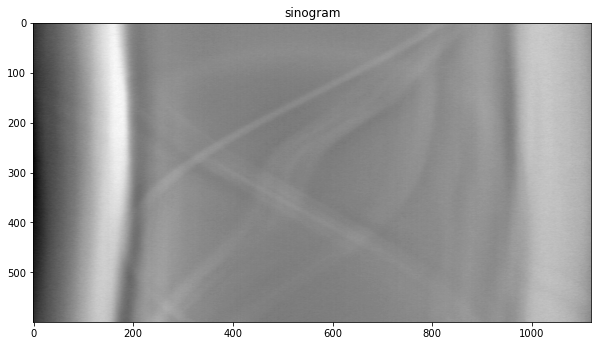

In [10]:
plt.imshow(np.sum(proj, axis=1), cmap="gray")
plt.title("sinogram")
plt.show()

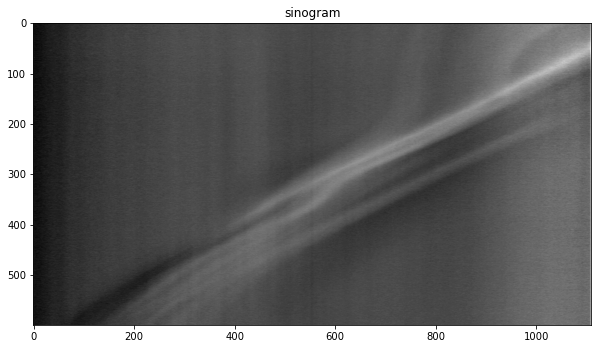

In [11]:
plt.imshow(np.sum(proj, axis=2), cmap="gray")
plt.title("sinogram")
plt.show()

In [12]:
ImageSliceViewer3D(np.transpose(proj, (1,2,0)))#Look at slice 439

In [13]:
recon = tomopy.recon(np.expand_dims(proj[439,:,:], axis=1), theta, center=rot_center, algorithm='gridrec', ncore=32)
plt.imshow(recon[0, :, :])
ImageSliceViewer3D(recon)

INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...


In [14]:
np.save("projections.npy", proj, allow_pickle=False, fix_imports = True)

In [15]:
np.save("theta.npy", theta, allow_pickle=False, fix_imports = True)

In [16]:
niter = 32  # number of ADMM iterations
titer = 4  # number of inner tomography iterations

In [17]:
nzp = 1 # number of slices to process simultaniously by gpu
ngpus = 1 # number of gpus

In [18]:
proj_swp = np.swapaxes(proj, 0,1)
[nz, ntheta, n] = proj_swp.shape
phi = takephi(ntheta) 
m = phi.shape[0] # number of basis functions

NameError: name 'takephi' is not defined

In [ ]:

def dataplot(slice):
    plt.figure(figsize=(15,8))
    plt.ylabel('x')
    plt.xlabel('theta')    
    plt.imshow(data[slice].swapaxes(0,1),cmap='gray')

In [ ]:
data = proj_swp
interact(dataplot,  slice=widgets.IntSlider(min=0, max=data.shape[0]-1,value=data.shape[0]//2));

In [ ]:
cl = rectv_gpu.Solver(n, ntheta, m, nz, nzp, ngpus)

In [ ]:
rtv = cl.recon(data, theta, phi, rot_center=rot_center,
              lambda0=lambda0, lambda1=lambda1,
              niter=niter, titer=titer)

In [ ]:
rtv.shape

In [ ]:
rtv.shape

In [ ]:
plt.imshow(rtv[0,8,:,:])

In [ ]:
#np.count_nonzero(rtv)

In [ ]:
ImageSliceViewer3D(projs)

In [19]:
#%matplotlib inline

# To prevent automatic figure display when execution of the cell ends
#%config InlineBackend.close_figures=False 

#import matplotlib.pyplot as plt
#import numpy as np

#from IPython.html import widgets
#from IPython.display import display,clear_output
#from functools import partial
import ipywidgets as widgets
from IPython.display import display


plt.ioff()
ax=plt.gca()

out=widgets.Output()
button=widgets.BoundedIntText(min=0, max=projs.shape[0]-1,continuous_update=False, description='Image Slice:')

vbox=widgets.VBox(children=(out,button))
display(vbox)

#def button_callback(counter, w):
#    counter.increment()    
#    ax.clear()
#    ax.imshow(projs[counter.value,:,:])
#    with out:
#        clear_output(wait=True)
#        display(ax.figure)

def callback(change): 
    ax.clear()
    ax.imshow(projs[change['new'],:,:])
    with out:
        clear_output(wait=True)
        display(ax.figure)

button.observe(callback, names='value')
#interact = widgets.interact(callback, z=widgets.IntText(continuous_update=False, description='Image Slice:'))
#isplay(button)

#... sometime later

#if counter.value > 0:
#    print(counter.value)

#plt.ioff()
#ax=plt.gca()

#out=widgets.Output()
#button=widgets.Button(description='Next')
#vbox=widgets.VBox(children=(out,button))
#display(vbox)
#i = 0

#def click(counter,b):
#    counter.increment()
#    ax.clear()
#    ax.imshow(projs[0,:,:])
#    with out:
#        clear_output(wait=True)
#        display(ax.figure)

#button.on_click(partial(click, i))
#click(None)

In [ ]:
from ImageSliceViewer3D import *

In [ ]:
ImageSliceViewer3D(proj_swp)

In [ ]:
#Look at slice 451 and describe the sinogram - also try doing 2D recon here!

In [ ]:
proj.shape

In [ ]:
recon.shape


In [ ]:
a = np.sum(proj, axis=1)
a.shape

In [ ]:
plt.imshow(recon[0,:,:])

In [ ]:
plt.show()

In [ ]:
from skimage.transform import iradon
from skimage.transform import iradon_sart

sinogram = np.transpose(proj, (1,2,0))[100,:,:]

reconstruction_fbp = iradon_sart(sinogram, theta=np.linspace(0,180,600))
#error = reconstruction_fbp - image
#print(f"FBP rms reconstruction error: {np.sqrt(np.mean(error**2)):.3g}")

plt.imshow(reconstruction_fbp)
plt.show()

In [ ]:
from skimage.transform import iradon
from skimage.transform import iradon_sart

sinogram = np.transpose(proj, (1,2,0))[10,:,:]

reconstruction_fbp = iradon_sart(sinogram, theta=np.linspace(0,180,600))
#error = reconstruction_fbp - image
#print(f"FBP rms reconstruction error: {np.sqrt(np.mean(error**2)):.3g}")

plt.imshow(reconstruction_fbp)
plt.show()